In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# remove pandas colomn limit
pd.set_option('display.max_columns', None)


* Im going to create one data frame with all the points and features and then I will cluster them for each segement using a time series aproch

* then i will use those cluster lables for the second data frame where it have a row for each segment , with speed acceleration and other features and their mean , median , MAX , MIN and std

* and i will use that second dataframe to do a clustering based on driving behavior , 

* then i will try to find a meaning those clusters have. then for the training dataset i have to train a clasifire that will predict the cluster of each future segment

* then using those data i will pridict the arrival time.

* if that was not enough i will train a regression model to predict the speed , acceleration and other features for each new upcoming segemnt, and then i will use that to predict the arrival time


In [2]:
# import csv DataOut\bus_running_times_feature_added_all_moddedDF.csv
running_time_features = pd.read_csv('../DataOut/bus_running_times_feature_added_all_moddedDF.csv')
# read csv DataOut\bus_trip_all_points_moddedDF.csv 
bus_trip_speed_and_other_features = pd.read_csv('../DataOut/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance_and_accDiff.csv')

In [3]:
# # select a random set of 10 trip ids , sed a known seed for reproducibility
# np.random.seed(42)
# trip_ids = np.random.choice(bus_trip_speed_and_other_features.trip_id.unique(), 10, replace=False)
# # select only the trips with the selected trip ids
# bus_trip_speed_and_other_features = bus_trip_speed_and_other_features[bus_trip_speed_and_other_features.trip_id.isin(trip_ids)]
# running_time_features= running_time_features[running_time_features.trip_id.isin(trip_ids)]
# # reset the index
# bus_trip_speed_and_other_features.reset_index(drop=True, inplace=True)
# running_time_features.reset_index(drop=True, inplace=True)

# trip_ids

In [4]:
# running_time_features=running_time_features[running_time_features['trip_id'].isin(trip_ids)]
# bus_trip_speed_and_other_features=bus_trip_speed_and_other_features[bus_trip_speed_and_other_features['trip_id'].isin(trip_ids)]

In [5]:
useless_features=['id','geometry','count',]
bus_trip_speed_and_other_features=bus_trip_speed_and_other_features.drop(useless_features,axis=1)

In [6]:
bus_trip_speed_and_other_features

deviceid           devicetime  latitude  longitude     speed  \
0             116  2021-10-16 08:03:19  7.293068  80.636430  14.03890   
1             116  2021-10-16 08:03:34  7.293043  80.637552  10.25920   
2             116  2021-10-16 08:03:49  7.292725  80.637707   7.55940   
3             116  2021-10-16 08:04:04  7.292292  80.637663   3.77970   
4             116  2021-10-16 08:04:19  7.291640  80.637455   9.17927   
...           ...                  ...       ...        ...       ...   
1159802       262  2022-08-09 10:55:05  7.290370  80.638812  20.51840   
1159803       262  2022-08-09 10:55:37  7.291380  80.637410   7.55940   
1159804       262  2022-08-09 10:55:38  7.291392  80.637387   7.55940   
1159805       262  2022-08-09 10:55:53  7.291295  80.636463  12.95900   
1159806       262  2022-08-09 10:56:15  7.291702  80.635213   5.93953   

               date      time bus_stop  trip_id  direction  acceleration  \
0        2021-10-16  08:03:19      NaN      2.0          1      0.323975   
1        2021-10-16  08:03:34      NaN      2.0          1     -0.251980   
2        2021-10-16  08:03:49      NaN      2.0          1     -0.179987   
3        2021-10-16  08:04:04      NaN      2.0          1     -0.251980   
4        2021-10-16  08:04:19      101      2.0          1      0.359971   
...             ...       ...      ...      ...        ...           ...   
1159802  2022-08-09  10:55:05      NaN   5586.0          2     -0.539900   
1159803  2022-08-09  10:55:37      NaN   5586.0          2     -0.404969   
1159804  2022-08-09  10:55:38      NaN   5586.0          2      0.000000   
1159805  2022-08-09  10:55:53      NaN   5586.0          2      0.359973   
1159806  2022-08-09  10:56:15     BT01   5586.0          2     -0.319067   

         radial_acceleration  distance_from_start        time_diff  acc_diff  \
0                   0.000000             0.000000              NaN       NaN   
1                   1.278067           123.738485  0 days 00:00:15 -0.575955   
2                   0.722300           163.044397  0 days 00:00:15  0.071993   
3                   0.048332           211.472339  0 days 00:00:15 -0.071993   
4                   1.052222           287.492821  0 days 00:00:15  0.611951   
...                      ...                  ...              ...       ...   
1159802             4.312238         16062.472333  0 days 00:00:01 -0.694171   
1159803             0.096588         16253.551165  0 days 00:00:32  0.134931   
1159804             0.588683         16256.436454  0 days 00:00:01  0.404969   
1159805             0.563965         16358.837456  0 days 00:00:15  0.359973   
1159806             0.000000         16503.931061  0 days 00:00:22 -0.679040   

         acceleration_der  
0                0.000000  
1               -0.038397  
2                0.004800  
3               -0.004800  
4                0.040797  
...                   ...  
1159802         -0.694171  
1159803          0.004217  
1159804          0.404969  
1159805          0.023998  
1159806         -0.030865  

[1159807 rows x 16 columns]

In [7]:
running_time_features

trip_id  deviceid  direction  segment        date start_time  \
0        4890.0     262.0        1.0      1.0  2021-10-01   06:39:49   
1        4890.0     262.0        1.0      2.0  2021-10-01   06:42:12   
2        4890.0     262.0        1.0      3.0  2021-10-01   06:45:42   
3        4890.0     262.0        1.0      4.0  2021-10-01   06:54:04   
4        4890.0     262.0        1.0      5.0  2021-10-01   06:57:19   
...         ...       ...        ...      ...         ...        ...   
197627   3462.0     123.0        2.0     28.0  2022-10-31   18:45:44   
197628   3462.0     123.0        2.0     29.0  2022-10-31   18:47:38   
197629   3462.0     123.0        2.0     30.0  2022-10-31   18:50:56   
197630   3462.0     123.0        2.0     31.0  2022-10-31   18:56:48   
197631   3462.0     123.0        2.0     32.0  2022-10-31   18:57:49   

        end_time         run_time  run_time_in_seconds  length  day_of_week  \
0       06:40:58  0 days 00:01:09                 69.0  0.6261          4.0   
1       06:45:42  0 days 00:03:30                210.0  1.2808          4.0   
2       06:53:58  0 days 00:08:16                496.0  2.1125          4.0   
3       06:57:19  0 days 00:03:15                195.0  1.5513          4.0   
4       06:58:56  0 days 00:01:37                 97.0  0.8450          4.0   
...          ...              ...                  ...     ...          ...   
197627  18:47:23          0:01:39                 99.0  0.8700          0.0   
197628  18:50:23          0:02:45                165.0  1.4000          0.0   
197629  18:56:33          0:05:37                337.0  2.5600          0.0   
197630  18:57:34          0:00:46                 46.0  0.4200          0.0   
197631  19:00:13          0:02:24                144.0  1.3000          0.0   

        time_of_day  Sunday/holiday  saturday  weekday/end  week_no  rt(w-1)  \
0              6.50             0.0         0            1      1.0     96.0   
1              6.50             0.0         0            1      1.0    247.0   
2              6.75             0.0         0            1      1.0    506.0   
3              6.75             0.0         0            1      1.0    192.0   
4              6.75             0.0         0            1      1.0    114.0   
...             ...             ...       ...          ...      ...      ...   
197627        18.75             0.0         0            1     42.0    120.0   
197628        18.75             0.0         0            1     42.0    218.0   
197629        18.75             0.0         0            1     42.0    391.0   
197630        18.75             0.0         0            1     42.0     65.0   
197631        18.75             0.0         0            1     42.0    172.0   

        rt(w-2)  rt(w-3)  rt(t-1)  rt(t-2)  rt(n-1)  rt(n-2)  rt(n-3)  \
0          96.0     96.0     96.0     96.0     96.0     96.0     96.0   
1         247.0    247.0    247.0    247.0     69.0    247.0    247.0   
2         506.0    506.0    506.0    506.0    210.0     69.0    506.0   
3         192.0    192.0    192.0    192.0    496.0    210.0     69.0   
4         114.0    114.0    114.0    114.0    195.0    496.0    210.0   
...         ...      ...      ...      ...      ...      ...      ...   
197627    120.0    120.0    120.0    120.0     63.0    156.0    197.0   
197628    218.0    218.0    218.0    218.0     99.0     63.0    156.0   
197629    391.0    391.0    391.0    391.0    165.0     99.0     63.0   
197630     65.0     65.0     65.0     65.0    337.0    165.0     99.0   
197631    172.0    172.0    172.0    172.0     46.0    337.0    165.0   

        hour_of_day   day  month  temp  precip  windspeed        conditions  \
0               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
1               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
2               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
3               6.0   1.0   10.0  20.0  

In [8]:
#print unique set of trip ids where direction is equal to 2
print(running_time_features[running_time_features['direction']==2]['trip_id'].unique())

[6540. 2369. 4891. ... 4889. 5906. 3462.]


Insert segment column 

In [9]:
# set Nan values in bus_stop column to 0
bus_trip_speed_and_other_features['bus_stop']=bus_trip_speed_and_other_features['bus_stop'].fillna(0)

In [10]:
ayyas_df = pd.read_csv('../DataOut/bus_running_times_feature_added_all_moddedDF.csv')

In [11]:

# bus_trip_speed_and_other_features['segment'] = 0
# for x in bus_trip_speed_and_other_features.trip_id.unique():
#     df = bus_trip_speed_and_other_features[bus_trip_speed_and_other_features['trip_id'] == x]
#     ayyas_tid_df = ayyas_df[ayyas_df['trip_id'] == x]

#     for index, row in df.iterrows():
#         for index2, row2 in ayyas_tid_df.iterrows():
#             # print(row)
#             print_counter = 0
#             # Check if 'start_time' and 'end_time' are not null (not missing values)
#             if pd.notna(row2['start_time']) and pd.notna(row2['end_time']):
#                 if row2['start_time'] <= row['time'] and row['time'] <= row2['end_time']:
#                     bus_trip_speed_and_other_features.loc[index, 'segment'] = row2['segment']
#                     break
                        

In [12]:
# bus_trip_speed_and_other_features.head(10)

In [13]:
# # bus_trip_speed_and_other_features save to csv 
# bus_trip_speed_and_other_features.to_csv('../DataOut/bus_trip_speed_and_other_features.csv', index=False)

In [14]:
# open bus_trip_speed_and_other_features csv
bus_trip_speed_and_other_features= pd.read_csv('../DataOut/bus_trip_speed_and_other_features.csv')

In [15]:
bus_trip_speed_and_other_features

deviceid           devicetime  latitude  longitude     speed  \
0             116  2021-10-16 08:03:19  7.293068  80.636430  14.03890   
1             116  2021-10-16 08:03:34  7.293043  80.637552  10.25920   
2             116  2021-10-16 08:03:49  7.292725  80.637707   7.55940   
3             116  2021-10-16 08:04:04  7.292292  80.637663   3.77970   
4             116  2021-10-16 08:04:19  7.291640  80.637455   9.17927   
...           ...                  ...       ...        ...       ...   
1159802       262  2022-08-09 10:55:05  7.290370  80.638812  20.51840   
1159803       262  2022-08-09 10:55:37  7.291380  80.637410   7.55940   
1159804       262  2022-08-09 10:55:38  7.291392  80.637387   7.55940   
1159805       262  2022-08-09 10:55:53  7.291295  80.636463  12.95900   
1159806       262  2022-08-09 10:56:15  7.291702  80.635213   5.93953   

               date      time bus_stop  trip_id  direction  acceleration  \
0        2021-10-16  08:03:19        0      2.0          1      0.323975   
1        2021-10-16  08:03:34        0      2.0          1     -0.251980   
2        2021-10-16  08:03:49        0      2.0          1     -0.179987   
3        2021-10-16  08:04:04        0      2.0          1     -0.251980   
4        2021-10-16  08:04:19      101      2.0          1      0.359971   
...             ...       ...      ...      ...        ...           ...   
1159802  2022-08-09  10:55:05        0   5586.0          2     -0.539900   
1159803  2022-08-09  10:55:37        0   5586.0          2     -0.404969   
1159804  2022-08-09  10:55:38        0   5586.0          2      0.000000   
1159805  2022-08-09  10:55:53        0   5586.0          2      0.359973   
1159806  2022-08-09  10:56:15     BT01   5586.0          2     -0.319067   

         radial_acceleration  distance_from_start        time_diff  acc_diff  \
0                   0.000000             0.000000              NaN       NaN   
1                   1.278067           123.738485  0 days 00:00:15 -0.575955   
2                   0.722300           163.044397  0 days 00:00:15  0.071993   
3                   0.048332           211.472339  0 days 00:00:15 -0.071993   
4                   1.052222           287.492821  0 days 00:00:15  0.611951   
...                      ...                  ...              ...       ...   
1159802             4.312238         16062.472333  0 days 00:00:01 -0.694171   
1159803             0.096588         16253.551165  0 days 00:00:32  0.134931   
1159804             0.588683         16256.436454  0 days 00:00:01  0.404969   
1159805             0.563965         16358.837456  0 days 00:00:15  0.359973   
1159806             0.000000         16503.931061  0 days 00:00:22 -0.679040   

         acceleration_der  segment  
0                0.000000        1  
1               -0.038397        1  
2                0.004800        1  
3               -0.004800        1  
4                0.040797        1  
...                   ...      ...  
1159802         -0.694171        0  
1159803          0.004217        0  
1159804          0.404969        0  
1159805          0.023998        0  
1159806         -0.030865        0  

[1159807 rows x 17 columns]

# TS cluster segemnts

In [16]:
# df_for_seg_ts_clustering = bus_trip_speed_and_other_features[['trip_id','segment','time','distance_from_start','speed','acceleration','radial_acceleration','acceleration_der']]
# # drop rows where segment is 0
# df_for_seg_ts_clustering = df_for_seg_ts_clustering[df_for_seg_ts_clustering['segment'] != 0]
# df_for_seg_ts_clustering

In [17]:
# import pandas as pd

# # Assuming df_for_seg_ts_clustering is your DataFrame

# # Convert the 'time' column to datetime objects
# df_for_seg_ts_clustering['time'] = pd.to_datetime(df_for_seg_ts_clustering['time'], format='%H:%M:%S')

# # Group by 'trip_id' and 'segment'
# grouped = df_for_seg_ts_clustering.groupby(['trip_id', 'segment'])

# # Define a function to calculate the time difference in seconds within each group
# def calculate_time_diff(group):
#     group['time'] = (group['time'] - group['time'].min()).dt.total_seconds().astype(int)
#     return group

# # Apply the function to each group and concatenate the results
# df_for_seg_ts_clustering = grouped.apply(calculate_time_diff)


In [18]:
# # Print the resulting DataFrame
# df_for_seg_ts_clustering[df_for_seg_ts_clustering['trip_id'] == 476].head(50)

In [19]:
# df_for_seg_ts_clustering=df_for_seg_ts_clustering.drop(['trip_id','segment'],axis=1)
# df_for_seg_ts_clustering=df_for_seg_ts_clustering.reset_index()
# # drop level_2 column
# df_for_seg_ts_clustering = df_for_seg_ts_clustering.drop('level_2',axis=1)


In [20]:
# # Group by 'segment' and calculate the maximum time in seconds for each segment within each trip_id
# grouped = df_for_seg_ts_clustering.groupby(['segment', 'trip_id'])['time'].max()

# # Calculate the average total time length for each segment
# segment_avg_times = grouped.groupby('segment').mean()

# # Round the mean value to the nearest 15th multiplier integer
# segment_avg_times_rounded = (segment_avg_times / 15).round() * 15 

# # Convert the result to a dictionary
# segment_avg_times_dict = segment_avg_times_rounded.to_dict()

# # Print the dictionary
# print(segment_avg_times_dict)


In [21]:
# df_for_seg_ts_clustering

In [22]:
# import pandas as pd
# import numpy as np

# # Assuming df_for_seg_ts_clustering is your DataFrame with the time adjustments
# # Assuming segment_avg_times_dict is the dictionary of rounded average times you calculated earlier

# # Create an empty list to store dictionaries of rows
# adjusted_rows = []

# for tid in df_for_seg_ts_clustering['trip_id'].unique():
#     for seg in df_for_seg_ts_clustering[df_for_seg_ts_clustering['trip_id'] == tid]['segment'].unique():
#         # Iterate through i by steps of 15 from 0 to the maximum time in seconds for the segment
#         for i in range(0, int(segment_avg_times_dict[seg])+15, 15):
#             # Check if the row in df_for_seg_ts_clustering where trip_id is equal to tid, segment is equal to seg, and time is equal to i exists
#             if df_for_seg_ts_clustering[(df_for_seg_ts_clustering['trip_id'] == tid) & (df_for_seg_ts_clustering['segment'] == seg) & (df_for_seg_ts_clustering['time'] == i)].shape[0] > 0:
#                 # Append the row to the list of adjusted rows
#                 adjusted_rows.append(df_for_seg_ts_clustering[(df_for_seg_ts_clustering['trip_id'] == tid) & (df_for_seg_ts_clustering['segment'] == seg) & (df_for_seg_ts_clustering['time'] == i)].iloc[0].to_dict())
#             else:
#                 # Create a new dictionary with the same trip_id, segment, and time equal to i and append it to the list of adjusted rows
#                 adjusted_rows.append({'trip_id': tid, 'segment': seg, 'time': i})

# # Create a DataFrame from the list of dictionaries
# adjusted_df = pd.DataFrame(adjusted_rows)

# # Sort the adjusted DataFrame
# adjusted_df.sort_values(by=['trip_id', 'segment', 'time'], inplace=True)

# # Reset the index
# adjusted_df.reset_index(drop=True, inplace=True)

# # Print the adjusted DataFrame
# adjusted_df

In [23]:
# # save adjestted_df to  a csv
# adjusted_df.to_csv('../DataOut/adjusted_df.csv',index=False)

In [24]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming you have a DataFrame named 'adjusted_df' that contains your data

# # Filter the DataFrame for segment 2
# segment_2_data = adjusted_df[adjusted_df['segment'] == 2]

# # Group the data by 'trip_id'
# grouped_data = segment_2_data.groupby('trip_id')

# # Create a figure and axis for the plot
# fig, ax = plt.subplots(figsize=(10, 6))

# # Iterate through each group (trip_id) and plot speed vs. time
# for trip_id, group in grouped_data:
#     ax.plot(group['time'], group['speed'], label=f'Trip {trip_id}')

# # Set labels and title
# ax.set_xlabel('Time (seconds)')
# ax.set_ylabel('Speed')
# ax.set_title('Speed vs. Time for Segment 2')

# # Add a legend
# ax.legend()

# # Show the plot
# plt.grid()
# plt.show()


# Segment wise clustering

In [25]:
# Define the count_local_maxima_and_minima function
def count_local_maxima_and_minima(data):
    max_count = 0
    min_count = 0
    for i in range(1, len(data) - 1):
        if data['acceleration_der'].iloc[i] > data['acceleration_der'].iloc[i - 1] and \
           data['acceleration_der'].iloc[i] > data['acceleration_der'].iloc[i + 1] and \
           data['acceleration_der'].iloc[i] > 0.01:
            max_count += 1
        elif data['acceleration_der'].iloc[i] < data['acceleration_der'].iloc[i - 1] and \
             data['acceleration_der'].iloc[i] < data['acceleration_der'].iloc[i + 1] and \
             data['acceleration_der'].iloc[i] < -0.025:
            min_count += 1
    return max_count, min_count

# Group the data by 'segment' and 'trip_id' and apply the count_local_maxima_and_minima function to 'acceleration_der'
breaks_and_throttles = bus_trip_speed_and_other_features.groupby(['trip_id', 'deviceid', 'segment']).apply(count_local_maxima_and_minima)

# Convert the results into a DataFrame
breaks_and_throttles = breaks_and_throttles.apply(pd.Series)

# Reset the index to make 'trip_id', 'deviceid', and 'segment' regular columns
breaks_and_throttles = breaks_and_throttles.reset_index()

# Rename the columns for clarity
breaks_and_throttles.columns = ['trip_id', 'deviceid', 'segment', 'throttle_count', 'break_count']

# The 'segment_maxima_minima_counts' DataFrame now contains the counts of local maxima and minima of 'acceleration_der' in each segment and trip_id
print(breaks_and_throttles)


       trip_id  deviceid  segment  throttle_count  break_count
0          1.0       116        0               4            0
1          1.0       116       21               6            5
2          1.0       116       22               1            2
3          1.0       116       23               3            3
4          1.0       116       24               3            4
...        ...       ...      ...             ...          ...
78047   5587.0       262        9               1            0
78048   5587.0       262       10               4            3
78049   5587.0       262       11               1            1
78050   5587.0       262       14               2            1
78051   5587.0       262       15               6            6

[78052 rows x 5 columns]


In [26]:
# bus_trip_speed_and_other_featuresdrop rows with segment 0
bus_trip_speed_and_other_features = bus_trip_speed_and_other_features[bus_trip_speed_and_other_features['segment'] != 0]
# drop unneeded columns
bus_trip_speed_and_other_features = bus_trip_speed_and_other_features.drop(['latitude','longitude','date','time','bus_stop','time_diff','acc_diff','distance_from_start','devicetime'],axis=1)
# re order columns
bus_trip_speed_and_other_features = bus_trip_speed_and_other_features[['trip_id','segment','deviceid','speed','acceleration','radial_acceleration','acceleration_der']]

bus_trip_speed_and_other_features

trip_id  segment  deviceid     speed  acceleration  \
0            2.0        1       116  14.03890      0.323975   
1            2.0        1       116  10.25920     -0.251980   
2            2.0        1       116   7.55940     -0.179987   
3            2.0        1       116   3.77970     -0.251980   
4            2.0        1       116   9.17927      0.359971   
...          ...      ...       ...       ...           ...   
1159785   5586.0       32       262  12.95900      0.016364   
1159786   5586.0       32       262  12.41900     -0.540000   
1159787   5586.0       32       262   6.47948     -0.179985   
1159788   5586.0       32       262   7.01944      0.539960   
1159789   5586.0       32       262   5.39957     -0.053996   

         radial_acceleration  acceleration_der  
0                   0.000000          0.000000  
1                   1.278067         -0.038397  
2                   0.722300          0.004800  
3                   0.048332         -0.004800  
4                   1.052222          0.040797  
...                      ...               ...  
1159785             1.365805          0.000496  
1159786             1.315046         -0.556364  
1159787             0.372508          0.010910  
1159788             0.292198          0.719945  
1159789             0.149243         -0.019799  

[1071556 rows x 7 columns]

In [27]:
# group bus_trip_speed_and_other_features by segment and trip_id, take the mean , standard deviation , min , max , median of each other column as seperate columns
bus_trip_speed_and_other_features_grpd = bus_trip_speed_and_other_features.groupby(['segment','trip_id']).agg({'deviceid':['median'],'speed':['mean','std','min','max','median'],'acceleration':['mean','std','min','max','median'],'radial_acceleration':['mean','std','min','max','median'],'acceleration_der':['mean','std','min','max','median']}).reset_index()

bus_trip_speed_and_other_features_grpd

segment trip_id deviceid      speed                               \
                        median       mean       std      min       max   
0           1     2.0    116.0   7.636540  4.554339  0.00000  14.03890   
1           1     4.0    116.0   5.519560  3.558986  0.00000   9.71923   
2           1     6.0    116.0   5.399570  3.488891  0.00000   9.71923   
3           1     8.0    116.0   6.599478  3.134288  0.00000  10.25920   
4           1    10.0    116.0   5.075596  3.221693  0.00000   9.71923   
...       ...     ...      ...        ...       ...      ...       ...   
72964      34  5566.0    262.0   6.959446  7.261597  0.00000  20.51840   
72965      34  5570.0    262.0  14.254866  5.102514  5.93953  18.35850   
72966      34  5575.0    262.0  15.334774  4.227548  9.17927  21.05830   
72967      34  5576.0    262.0   7.619398  4.756872  0.00000  15.11880   
72968      34  5580.0    262.0  10.413467  3.324358  4.85961  14.03890   

                 acceleration                                          \
         median          mean       std       min       max    median   
0       8.63931 -8.742162e-02  0.335023 -0.575954  0.359971 -0.179987   
1       7.01944  0.000000e+00  0.339119 -0.539957  0.467963 -0.035997   
2       5.93953  0.000000e+00  0.377970 -0.647949  0.431965  0.071995   
3       7.01944 -5.599556e-02  0.140702 -0.287977  0.143990  0.000000   
4       5.39957 -1.110223e-17  0.304028 -0.323974  0.647949 -0.053996   
...         ...           ...       ...       ...       ...       ...   
72964   4.85961 -2.080314e-02  1.094466 -1.799850  1.169907  0.392696   
72965  16.19870  3.599720e-02  0.548292 -0.791938  0.647951  0.107993   
72966  15.11880 -1.079911e-01  0.434954 -0.791935  0.395967 -0.071993   
72967   7.55940  1.839848e-01  1.211958 -1.889850  2.699780  0.071993   
72968  11.33910 -1.300979e-01  0.188062 -0.539960  0.000000 -0.098174   

      radial_acceleration                                    acceleration_der  \
                     mean       std  min       max    median             mean   
0                0.534319  0.528350  0.0  1.278067  0.639311        -0.008571   
1                0.302178  0.342921  0.0  0.872557  0.092952        -0.001067   
2                0.351493  0.520755  0.0  1.506472  0.097039        -0.001333   
3                0.294084  0.337139  0.0  0.995937  0.117268        -0.002400   
4                0.257264  0.403752  0.0  1.040735  0.048050        -0.000240   
...                   ...       ...  ...       ...       ...              ...   
72964            0.301851  0.359403  0.0  1.106294  0.208520         0.033664   
72965            0.288076  0.318871  0.0  0.629059  0.178158        -0.024958   
72966            0.532967  0.304443  0.0  0.755660  0.661078        -0.007199   
72967            0.251299  0.386781  0.0  1.236341  0.186676         0.453274   
72968            1.013965  1.596389  0.0  4.321553  0.116131        -0.061627   

                                               
            std       min       max    median  
0      0.027878 -0.038397  0.040797 -0.004800  
1      0.034446 -0.040797  0.057595 -0.016799  
2      0.042272 -0.047996  0.059995 -0.014399  
3      0.010732 -0.016799  0.019199 -0.002400  
4      0.031360 -0.052796  0.059995 -0.003600  
...         ...       ...       ...       ...  
72964  0.216391 -0.191983  0.424057  0.015599  
72965  0.027811 -0.059995  0.016799 -0.028798  
72966  0.042828 -0.079193  0.031197  0.007200  
72967  1.556138 -0.346473  4.589630 -0.009599  
72968  0.156946 -0.411399  0.035997 -0.001200  

[72969 rows x 23 columns]

In [28]:
# dont have multi index columns
bus_trip_speed_and_other_features_grpd.columns = [' '.join(col).strip() for col in bus_trip_speed_and_other_features_grpd.columns.values]
# rename deviceid median to deviceid
bus_trip_speed_and_other_features_grpd.rename(columns={'deviceid median':'deviceid'}, inplace=True)
bus_trip_speed_and_other_features_grpd

segment  trip_id  deviceid  speed mean  speed std  speed min  \
0            1      2.0     116.0    7.636540   4.554339    0.00000   
1            1      4.0     116.0    5.519560   3.558986    0.00000   
2            1      6.0     116.0    5.399570   3.488891    0.00000   
3            1      8.0     116.0    6.599478   3.134288    0.00000   
4            1     10.0     116.0    5.075596   3.221693    0.00000   
...        ...      ...       ...         ...        ...        ...   
72964       34   5566.0     262.0    6.959446   7.261597    0.00000   
72965       34   5570.0     262.0   14.254866   5.102514    5.93953   
72966       34   5575.0     262.0   15.334774   4.227548    9.17927   
72967       34   5576.0     262.0    7.619398   4.756872    0.00000   
72968       34   5580.0     262.0   10.413467   3.324358    4.85961   

       speed max  speed median  acceleration mean  acceleration std  \
0       14.03890       8.63931      -8.742162e-02          0.335023   
1        9.71923       7.01944       0.000000e+00          0.339119   
2        9.71923       5.93953       0.000000e+00          0.377970   
3       10.25920       7.01944      -5.599556e-02          0.140702   
4        9.71923       5.39957      -1.110223e-17          0.304028   
...          ...           ...                ...               ...   
72964   20.51840       4.85961      -2.080314e-02          1.094466   
72965   18.35850      16.19870       3.599720e-02          0.548292   
72966   21.05830      15.11880      -1.079911e-01          0.434954   
72967   15.11880       7.55940       1.839848e-01          1.211958   
72968   14.03890      11.33910      -1.300979e-01          0.188062   

       acceleration min  acceleration max  acceleration median  \
0             -0.575954          0.359971            -0.179987   
1             -0.539957          0.467963            -0.035997   
2             -0.647949          0.431965             0.071995   
3             -0.287977          0.143990             0.000000   
4             -0.323974          0.647949            -0.053996   
...                 ...               ...                  ...   
72964         -1.799850          1.169907             0.392696   
72965         -0.791938          0.647951             0.107993   
72966         -0.791935          0.395967            -0.071993   
72967         -1.889850          2.699780             0.071993   
72968         -0.539960          0.000000            -0.098174   

       radial_acceleration mean  radial_acceleration std  \
0                      0.534319                 0.528350   
1                      0.302178                 0.342921   
2                      0.351493                 0.520755   
3                      0.294084                 0.337139   
4                      0.257264                 0.403752   
...                         ...                      ...   
72964                  0.301851                 0.359403   
72965                  0.288076                 0.318871   
72966                  0.532967                 0.304443   
72967                  0.251299                 0.386781   
72968                  1.013965                 1.596389   

       radial_acceleration min  radial_acceleration max  \
0                          0.0                 1.278067   
1                          0.0                 0.872557   
2                          0.0                 1.506472   
3                          0.0                 0.995937   
4                          0.0                 1.040735   
...                        ...                      ...   
72964                      0.0                 1.106294   
72965                      0.0                 0.629059   
72966                      0.0                 0.755660   
72967                      0.0                 1.236341   
72968                      0.0                 4.321553   

       radial_acceleration median  acceleration_der mean  \
0                 

In [29]:
# left join breaks_and_throttles to bus_trip_speed_and_other_features_grpd using trip_id and segment as keys
bus_trip_speed_and_other_features_grpd = pd.merge(bus_trip_speed_and_other_features_grpd,breaks_and_throttles,how='left',on=['trip_id','segment','deviceid'])
bus_trip_speed_and_other_features_grpd

segment  trip_id  deviceid  speed mean  speed std  speed min  \
0            1      2.0     116.0    7.636540   4.554339    0.00000   
1            1      4.0     116.0    5.519560   3.558986    0.00000   
2            1      6.0     116.0    5.399570   3.488891    0.00000   
3            1      8.0     116.0    6.599478   3.134288    0.00000   
4            1     10.0     116.0    5.075596   3.221693    0.00000   
...        ...      ...       ...         ...        ...        ...   
72964       34   5566.0     262.0    6.959446   7.261597    0.00000   
72965       34   5570.0     262.0   14.254866   5.102514    5.93953   
72966       34   5575.0     262.0   15.334774   4.227548    9.17927   
72967       34   5576.0     262.0    7.619398   4.756872    0.00000   
72968       34   5580.0     262.0   10.413467   3.324358    4.85961   

       speed max  speed median  acceleration mean  acceleration std  \
0       14.03890       8.63931      -8.742162e-02          0.335023   
1        9.71923       7.01944       0.000000e+00          0.339119   
2        9.71923       5.93953       0.000000e+00          0.377970   
3       10.25920       7.01944      -5.599556e-02          0.140702   
4        9.71923       5.39957      -1.110223e-17          0.304028   
...          ...           ...                ...               ...   
72964   20.51840       4.85961      -2.080314e-02          1.094466   
72965   18.35850      16.19870       3.599720e-02          0.548292   
72966   21.05830      15.11880      -1.079911e-01          0.434954   
72967   15.11880       7.55940       1.839848e-01          1.211958   
72968   14.03890      11.33910      -1.300979e-01          0.188062   

       acceleration min  acceleration max  acceleration median  \
0             -0.575954          0.359971            -0.179987   
1             -0.539957          0.467963            -0.035997   
2             -0.647949          0.431965             0.071995   
3             -0.287977          0.143990             0.000000   
4             -0.323974          0.647949            -0.053996   
...                 ...               ...                  ...   
72964         -1.799850          1.169907             0.392696   
72965         -0.791938          0.647951             0.107993   
72966         -0.791935          0.395967            -0.071993   
72967         -1.889850          2.699780             0.071993   
72968         -0.539960          0.000000            -0.098174   

       radial_acceleration mean  radial_acceleration std  \
0                      0.534319                 0.528350   
1                      0.302178                 0.342921   
2                      0.351493                 0.520755   
3                      0.294084                 0.337139   
4                      0.257264                 0.403752   
...                         ...                      ...   
72964                  0.301851                 0.359403   
72965                  0.288076                 0.318871   
72966                  0.532967                 0.304443   
72967                  0.251299                 0.386781   
72968                  1.013965                 1.596389   

       radial_acceleration min  radial_acceleration max  \
0                          0.0                 1.278067   
1                          0.0                 0.872557   
2                          0.0                 1.506472   
3                          0.0                 0.995937   
4                          0.0                 1.040735   
...                        ...                      ...   
72964                      0.0                 1.106294   
72965                      0.0                 0.629059   
72966                      0.0                 0.755660   
72967                      0.0                 1.236341   
72968                      0.0                 4.321553   

       radial_acceleration median  acceleration_der mean  \
0                 

In [30]:
# check for null values
bus_trip_speed_and_other_features_grpd.isnull().sum()

segment                        0
trip_id                        0
deviceid                       0
speed mean                     0
speed std                     20
speed min                      0
speed max                      0
speed median                   0
acceleration mean              0
acceleration std              20
acceleration min               0
acceleration max               0
acceleration median            0
radial_acceleration mean       0
radial_acceleration std       20
radial_acceleration min        0
radial_acceleration max        0
radial_acceleration median     0
acceleration_der mean          0
acceleration_der std          20
acceleration_der min           0
acceleration_der max           0
acceleration_der median        0
throttle_count                 0
break_count                    0
dtype: int64

In [31]:
# drop nan
bus_trip_speed_and_other_features_grpd = bus_trip_speed_and_other_features_grpd.dropna()

In [32]:
# create a new feature with total break_count per segment
bus_trip_speed_and_other_features_grpd['total_break_count_per_segment'] = bus_trip_speed_and_other_features_grpd.groupby('segment')['break_count'].transform('sum')
bus_trip_speed_and_other_features_grpd

C:\Users\gw\AppData\Local\Temp\ipykernel_25444\1710480790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_trip_speed_and_other_features_grpd['total_break_count_per_segment'] = bus_trip_speed_and_other_features_grpd.groupby('segment')['break_count'].transform('sum')


segment  trip_id  deviceid  speed mean  speed std  speed min  \
0            1      2.0     116.0    7.636540   4.554339    0.00000   
1            1      4.0     116.0    5.519560   3.558986    0.00000   
2            1      6.0     116.0    5.399570   3.488891    0.00000   
3            1      8.0     116.0    6.599478   3.134288    0.00000   
4            1     10.0     116.0    5.075596   3.221693    0.00000   
...        ...      ...       ...         ...        ...        ...   
72964       34   5566.0     262.0    6.959446   7.261597    0.00000   
72965       34   5570.0     262.0   14.254866   5.102514    5.93953   
72966       34   5575.0     262.0   15.334774   4.227548    9.17927   
72967       34   5576.0     262.0    7.619398   4.756872    0.00000   
72968       34   5580.0     262.0   10.413467   3.324358    4.85961   

       speed max  speed median  acceleration mean  acceleration std  \
0       14.03890       8.63931      -8.742162e-02          0.335023   
1        9.71923       7.01944       0.000000e+00          0.339119   
2        9.71923       5.93953       0.000000e+00          0.377970   
3       10.25920       7.01944      -5.599556e-02          0.140702   
4        9.71923       5.39957      -1.110223e-17          0.304028   
...          ...           ...                ...               ...   
72964   20.51840       4.85961      -2.080314e-02          1.094466   
72965   18.35850      16.19870       3.599720e-02          0.548292   
72966   21.05830      15.11880      -1.079911e-01          0.434954   
72967   15.11880       7.55940       1.839848e-01          1.211958   
72968   14.03890      11.33910      -1.300979e-01          0.188062   

       acceleration min  acceleration max  acceleration median  \
0             -0.575954          0.359971            -0.179987   
1             -0.539957          0.467963            -0.035997   
2             -0.647949          0.431965             0.071995   
3             -0.287977          0.143990             0.000000   
4             -0.323974          0.647949            -0.053996   
...                 ...               ...                  ...   
72964         -1.799850          1.169907             0.392696   
72965         -0.791938          0.647951             0.107993   
72966         -0.791935          0.395967            -0.071993   
72967         -1.889850          2.699780             0.071993   
72968         -0.539960          0.000000            -0.098174   

       radial_acceleration mean  radial_acceleration std  \
0                      0.534319                 0.528350   
1                      0.302178                 0.342921   
2                      0.351493                 0.520755   
3                      0.294084                 0.337139   
4                      0.257264                 0.403752   
...                         ...                      ...   
72964                  0.301851                 0.359403   
72965                  0.288076                 0.318871   
72966                  0.532967                 0.304443   
72967                  0.251299                 0.386781   
72968                  1.013965                 1.596389   

       radial_acceleration min  radial_acceleration max  \
0                          0.0                 1.278067   
1                          0.0                 0.872557   
2                          0.0                 1.506472   
3                          0.0                 0.995937   
4                          0.0                 1.040735   
...                        ...                      ...   
72964                      0.0                 1.106294   
72965                      0.0                 0.629059   
72966                      0.0                 0.755660   
72967                      0.0                 1.236341   
72968                      0.0                 4.321553   

       radial_acceleration median  acceleration_der mean  \
0                 

## K means clustering

In [33]:
# standardize the data
scaler = StandardScaler()
# fit and transform the data
scaled_data = scaler.fit_transform(bus_trip_speed_and_other_features_grpd.drop(['trip_id','segment','deviceid'],axis=1))
# create a dataframe with the scaled data
scaled_data_df = pd.DataFrame(scaled_data,columns=bus_trip_speed_and_other_features_grpd.drop(['trip_id','segment','deviceid'],axis=1).columns)
scaled_data_df

speed mean  speed std  speed min  speed max  speed median  \
0       -0.848010  -1.127173  -0.258877  -1.173430     -0.506165   
1       -1.586665  -1.626009  -0.258877  -2.069498     -0.913877   
2       -1.628532  -1.661138  -0.258877  -2.069498     -1.185685   
3       -1.209861  -1.838853  -0.258877  -1.957487     -0.913877   
4       -1.741573  -1.795048  -0.258877  -2.069498     -1.321589   
...           ...        ...        ...        ...           ...   
72944   -1.084261   0.229610  -0.258877   0.170671     -1.457494   
72945    1.461252  -0.852447   2.326704  -0.277377      1.396490   
72946    1.838053  -1.290949   3.737019   0.282667      1.124685   
72947   -0.853991  -1.025670  -0.258877  -0.949417     -0.777973   
72948    0.120914  -1.743596   1.856596  -1.173430      0.173356   

       acceleration mean  acceleration std  acceleration min  \
0               0.474157         -1.302635          1.190994   
1               0.749626         -1.296365          1.208634   
2               0.749626         -1.236895          1.155713   
3               0.573182         -1.600088          1.332116   
4               0.749626         -1.350079          1.314476   
...                  ...               ...               ...   
72944           0.684074         -0.140136          0.591227   
72945           0.863055         -0.976178          1.085151   
72946           0.409341         -1.149669          1.085153   
72947           1.329370          0.039713          0.547123   
72948           0.339682         -1.527593          1.208632   

       acceleration max  acceleration median  radial_acceleration mean  \
0             -1.112261            -1.445399                  0.178414   
1             -0.960276            -0.630119                 -0.737043   
2             -1.010938            -0.018666                 -0.542569   
3             -1.416230            -0.426304                 -0.768964   
4             -0.706966            -0.732033                 -0.914165   
...                 ...                  ...                       ...   
72944          0.027630             1.797166                 -0.738335   
72945         -0.706963             0.185161                 -0.792655   
72946         -1.061602            -0.833935                  0.173083   
72947          2.180753            -0.018673                 -0.937686   
72948         -1.618880            -0.982171                  2.069921   

       radial_acceleration std  radial_acceleration min  \
0                    -0.221172                -0.157043   
1                    -0.790546                -0.157043   
2                    -0.244493                -0.157043   
3                    -0.808301                -0.157043   
4                    -0.603758                -0.157043   
...                        ...                      ...   
72944                -0.739937                -0.157043   
72945                -0.864395                -0.157043   
72946                -0.908696                -0.157043   
72947                -0.655872                -0.157043   
72948                 3.058331                -0.157043   

       radial_acceleration max  radial_acceleration median  \
0                    -0.510973                    1.565398   
1                    -0.837366                   -0.762557   
2                    -0.327130                   -0.745146   
3                    -0.738058                   -0.658952   
4                    -0.702000                   -0.953880   
...                        ...                         ...   
72944                -0.649232                   -0.270138   
72945                -1.033356                   -0.399509   
72946                -0.931456                    1.658145   
72947                -0.544558                   -0.363214   
72948                 1.938715                   -0.663795   

       acceleration_der mean  acceleration_der std  acceleration_der min  \
0 

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

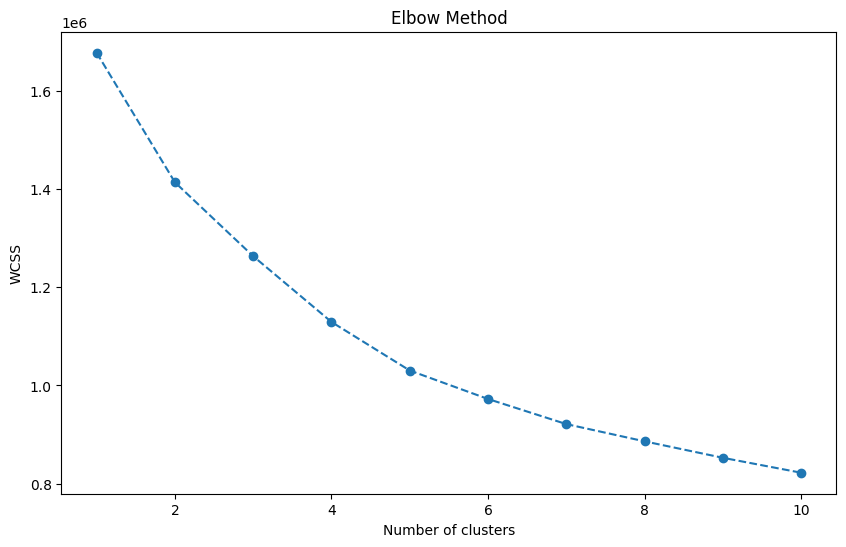

In [34]:
# implement elbow method to find optimal number of clusters
# drop trip_id and segment columns
X = scaled_data_df
# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# find optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
# plot the graph
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [35]:
# do a k means clustering on bus_trip_speed_and_other_features_grpd with 5 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_data_df)
# add a column to bus_trip_speed_and_other_features_grpd with the cluster labels
bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] = kmeans.labels_
# save bus_trip_speed_and_other_features_grpd to a csv
bus_trip_speed_and_other_features_grpd.to_csv('../DataOut/bus_trip_speed_and_other_features_grpd.csv',index=False)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gw\AppData\Local\Temp\ipykernel_25444\1811875740.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] = kmeans.labels_


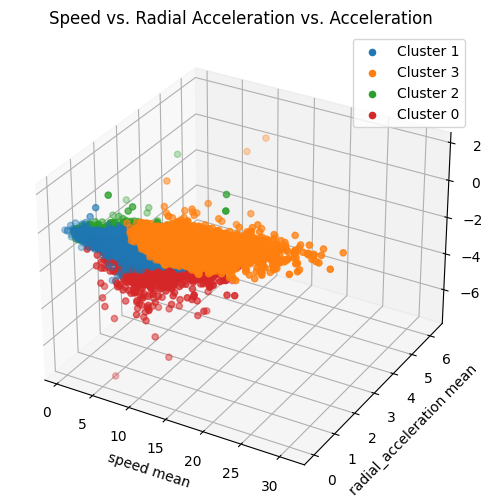

In [36]:
# visualize the clusters
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a DataFrame named 'bus_trip_speed_and_other_features_grpd' that contains your data

# Create a figure and axis for the plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

x_str='speed mean'
y_str='radial_acceleration mean'
z_str='acceleration mean'

# Iterate through each cluster and plot the mean speed, mean radial acceleration, and mean acceleration
for cluster in bus_trip_speed_and_other_features_grpd['Kmeans_cluster'].unique():
    ax.scatter(bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][x_str], 
               bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][y_str], 
               bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][z_str], 
               label=f'Cluster {cluster}')

# Set labels and title
ax.set_xlabel(f'{x_str}')
ax.set_ylabel(f'{y_str}')
ax.set_zlabel(f'{z_str}')
ax.set_title('Speed vs. Radial Acceleration vs. Acceleration')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [37]:
import plotly.graph_objects as go

# Create a 3D scatter plot with reduced dot size
fig = go.Figure()

for cluster in bus_trip_speed_and_other_features_grpd['Kmeans_cluster'].unique():
    cluster_data = bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['speed mean'],
        y=cluster_data['radial_acceleration mean'],
        z=cluster_data['acceleration mean'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=3),  # Adjust the size of the dots as needed
    ))

# Customize the layout
fig.update_layout(
    scene=dict(aspectmode='data'),
    title='Speed vs. Radial Acceleration vs. Acceleration'
)

# Show the interactive plot
fig.show()


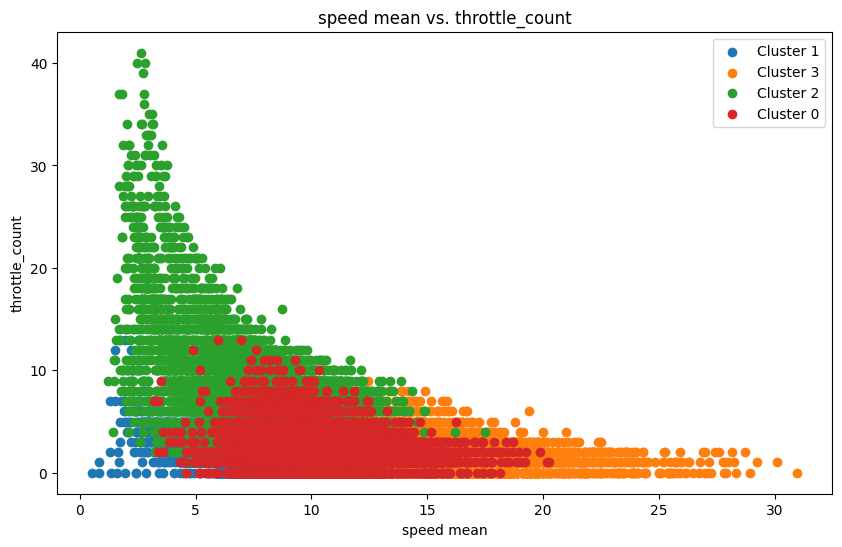

In [38]:
# plot a 2d scatter plot of the clusters
# Assuming you have a DataFrame named 'bus_trip_speed_and_other_features_grpd' that contains your data

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

x_str='speed mean'
y_str='throttle_count'

# Iterate through each cluster and plot the mean speed and mean acceleration
for cluster in bus_trip_speed_and_other_features_grpd['Kmeans_cluster'].unique():
    ax.scatter(bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][x_str], 
               bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][y_str], 
               label=f'Cluster {cluster}')

# Set labels and title
ax.set_xlabel(x_str)
ax.set_ylabel(y_str)
ax.set_title(f"{x_str} vs. {y_str}")

# Add a legend
ax.legend()

# Show the plot
plt.show()

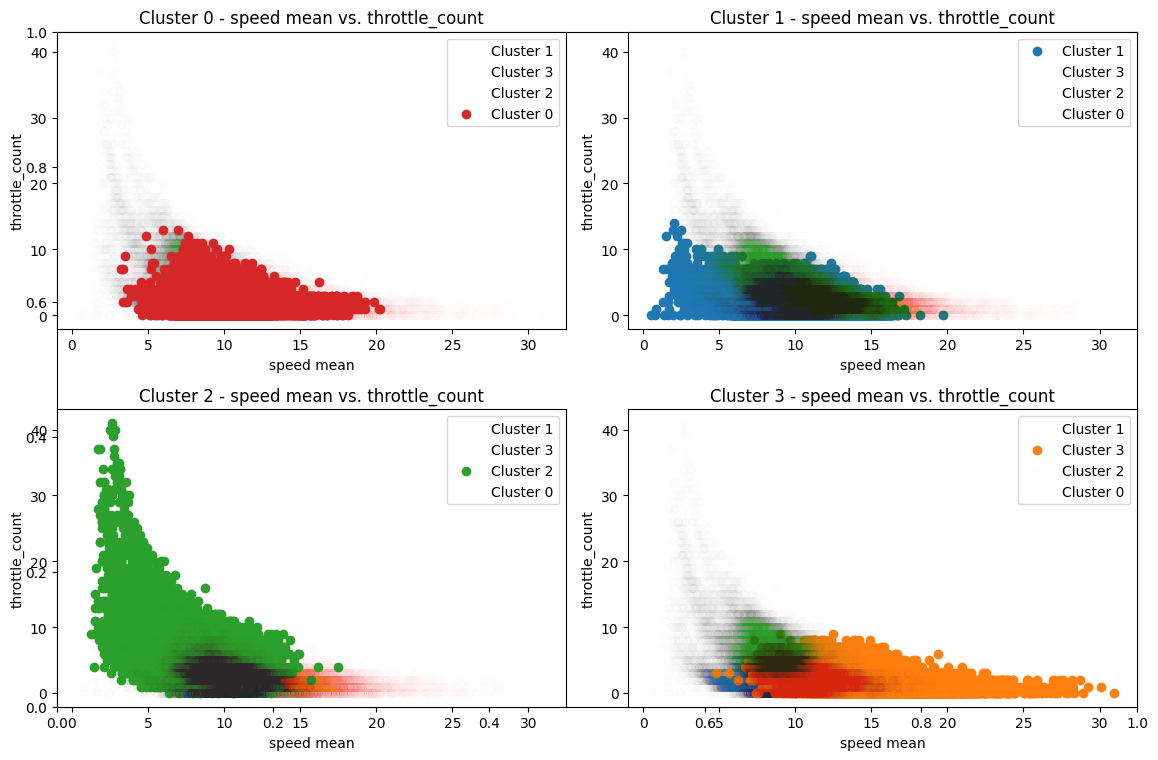

In [39]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 8))

x_str = 'speed mean'
y_str = 'throttle_count'

# Iterate through each cluster and create subplots for each cluster
for selected_cluster in bus_trip_speed_and_other_features_grpd['Kmeans_cluster'].unique():
    # Create a subplot for the selected cluster
    ax = fig.add_subplot(2, 2, selected_cluster + 1)  # Add 1 here to start indices from 1
    # Iterate through all clusters and plot the mean speed and mean acceleration
    for cluster in bus_trip_speed_and_other_features_grpd['Kmeans_cluster'].unique():
        alp = 1 if cluster == selected_cluster else 0.002
        ax.scatter(
            bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][x_str],
            bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][y_str],
            label=f'Cluster {cluster}',
            alpha=alp
        )

    # Set labels and title for the subplot
    ax.set_xlabel(x_str)
    ax.set_ylabel(y_str)
    ax.set_title(f"Cluster {selected_cluster} - {x_str} vs. {y_str}")
    ax.legend()

# Adjust the layout to prevent overlap of subplots
fig.tight_layout()

# Show the plot
plt.show()


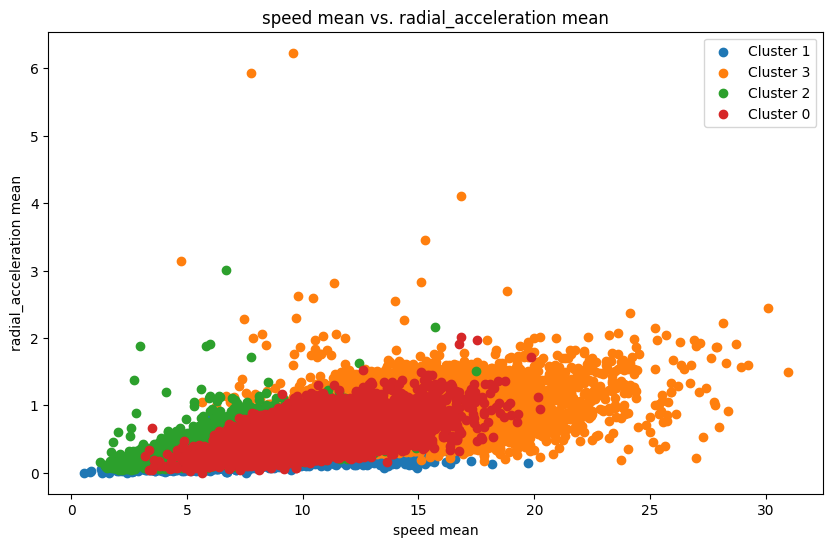

In [40]:
# plot a 2d scatter plot of the clusters
# Assuming you have a DataFrame named 'bus_trip_speed_and_other_features_grpd' that contains your data

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

x_str='speed mean'
y_str='radial_acceleration mean'

# Iterate through each cluster and plot the mean speed and mean acceleration
for cluster in bus_trip_speed_and_other_features_grpd['Kmeans_cluster'].unique():
    ax.scatter(bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][x_str], 
               bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['Kmeans_cluster'] == cluster][y_str], 
               label=f'Cluster {cluster}')

# Set labels and title
ax.set_xlabel(x_str)
ax.set_ylabel(y_str)
ax.set_title(f"{x_str} vs. {y_str}")

# Add a legend
ax.legend()

# Show the plot
plt.show()

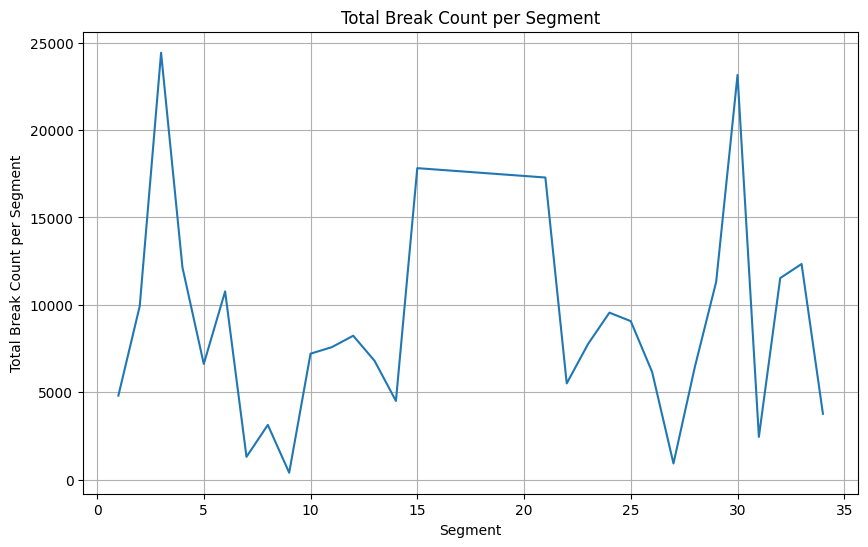

In [41]:
# plot a 2d line graph for segment vs total_break_count_per_segment
plt.figure(figsize=(10, 6))
plt.plot(bus_trip_speed_and_other_features_grpd['segment'], bus_trip_speed_and_other_features_grpd['total_break_count_per_segment'])
plt.xlabel('Segment')
plt.ylabel('Total Break Count per Segment')
plt.title('Total Break Count per Segment')
plt.grid()
plt.show()

In [42]:
bus_trip_speed_and_other_features_grpd

segment  trip_id  deviceid  speed mean  speed std  speed min  \
0            1      2.0     116.0    7.636540   4.554339    0.00000   
1            1      4.0     116.0    5.519560   3.558986    0.00000   
2            1      6.0     116.0    5.399570   3.488891    0.00000   
3            1      8.0     116.0    6.599478   3.134288    0.00000   
4            1     10.0     116.0    5.075596   3.221693    0.00000   
...        ...      ...       ...         ...        ...        ...   
72964       34   5566.0     262.0    6.959446   7.261597    0.00000   
72965       34   5570.0     262.0   14.254866   5.102514    5.93953   
72966       34   5575.0     262.0   15.334774   4.227548    9.17927   
72967       34   5576.0     262.0    7.619398   4.756872    0.00000   
72968       34   5580.0     262.0   10.413467   3.324358    4.85961   

       speed max  speed median  acceleration mean  acceleration std  \
0       14.03890       8.63931      -8.742162e-02          0.335023   
1        9.71923       7.01944       0.000000e+00          0.339119   
2        9.71923       5.93953       0.000000e+00          0.377970   
3       10.25920       7.01944      -5.599556e-02          0.140702   
4        9.71923       5.39957      -1.110223e-17          0.304028   
...          ...           ...                ...               ...   
72964   20.51840       4.85961      -2.080314e-02          1.094466   
72965   18.35850      16.19870       3.599720e-02          0.548292   
72966   21.05830      15.11880      -1.079911e-01          0.434954   
72967   15.11880       7.55940       1.839848e-01          1.211958   
72968   14.03890      11.33910      -1.300979e-01          0.188062   

       acceleration min  acceleration max  acceleration median  \
0             -0.575954          0.359971            -0.179987   
1             -0.539957          0.467963            -0.035997   
2             -0.647949          0.431965             0.071995   
3             -0.287977          0.143990             0.000000   
4             -0.323974          0.647949            -0.053996   
...                 ...               ...                  ...   
72964         -1.799850          1.169907             0.392696   
72965         -0.791938          0.647951             0.107993   
72966         -0.791935          0.395967            -0.071993   
72967         -1.889850          2.699780             0.071993   
72968         -0.539960          0.000000            -0.098174   

       radial_acceleration mean  radial_acceleration std  \
0                      0.534319                 0.528350   
1                      0.302178                 0.342921   
2                      0.351493                 0.520755   
3                      0.294084                 0.337139   
4                      0.257264                 0.403752   
...                         ...                      ...   
72964                  0.301851                 0.359403   
72965                  0.288076                 0.318871   
72966                  0.532967                 0.304443   
72967                  0.251299                 0.386781   
72968                  1.013965                 1.596389   

       radial_acceleration min  radial_acceleration max  \
0                          0.0                 1.278067   
1                          0.0                 0.872557   
2                          0.0                 1.506472   
3                          0.0                 0.995937   
4                          0.0                 1.040735   
...                        ...                      ...   
72964                      0.0                 1.106294   
72965                      0.0                 0.629059   
72966                      0.0                 0.755660   
72967                      0.0                 1.236341   
72968                      0.0                 4.321553   

       radial_acceleration median  acceleration_der mean  \
0                 

In [43]:
# read csv DataOut\bus_trip_all_points_moddedDF.csv
bus_running_times_feature_added_all_moddedDF=pd.read_csv('../DataOut/bus_running_times_feature_added_all_moddedDF.csv')

In [44]:
bus_running_times_feature_added_all_moddedDF

trip_id  deviceid  direction  segment        date start_time  \
0        4890.0     262.0        1.0      1.0  2021-10-01   06:39:49   
1        4890.0     262.0        1.0      2.0  2021-10-01   06:42:12   
2        4890.0     262.0        1.0      3.0  2021-10-01   06:45:42   
3        4890.0     262.0        1.0      4.0  2021-10-01   06:54:04   
4        4890.0     262.0        1.0      5.0  2021-10-01   06:57:19   
...         ...       ...        ...      ...         ...        ...   
197627   3462.0     123.0        2.0     28.0  2022-10-31   18:45:44   
197628   3462.0     123.0        2.0     29.0  2022-10-31   18:47:38   
197629   3462.0     123.0        2.0     30.0  2022-10-31   18:50:56   
197630   3462.0     123.0        2.0     31.0  2022-10-31   18:56:48   
197631   3462.0     123.0        2.0     32.0  2022-10-31   18:57:49   

        end_time         run_time  run_time_in_seconds  length  day_of_week  \
0       06:40:58  0 days 00:01:09                 69.0  0.6261          4.0   
1       06:45:42  0 days 00:03:30                210.0  1.2808          4.0   
2       06:53:58  0 days 00:08:16                496.0  2.1125          4.0   
3       06:57:19  0 days 00:03:15                195.0  1.5513          4.0   
4       06:58:56  0 days 00:01:37                 97.0  0.8450          4.0   
...          ...              ...                  ...     ...          ...   
197627  18:47:23          0:01:39                 99.0  0.8700          0.0   
197628  18:50:23          0:02:45                165.0  1.4000          0.0   
197629  18:56:33          0:05:37                337.0  2.5600          0.0   
197630  18:57:34          0:00:46                 46.0  0.4200          0.0   
197631  19:00:13          0:02:24                144.0  1.3000          0.0   

        time_of_day  Sunday/holiday  saturday  weekday/end  week_no  rt(w-1)  \
0              6.50             0.0         0            1      1.0     96.0   
1              6.50             0.0         0            1      1.0    247.0   
2              6.75             0.0         0            1      1.0    506.0   
3              6.75             0.0         0            1      1.0    192.0   
4              6.75             0.0         0            1      1.0    114.0   
...             ...             ...       ...          ...      ...      ...   
197627        18.75             0.0         0            1     42.0    120.0   
197628        18.75             0.0         0            1     42.0    218.0   
197629        18.75             0.0         0            1     42.0    391.0   
197630        18.75             0.0         0            1     42.0     65.0   
197631        18.75             0.0         0            1     42.0    172.0   

        rt(w-2)  rt(w-3)  rt(t-1)  rt(t-2)  rt(n-1)  rt(n-2)  rt(n-3)  \
0          96.0     96.0     96.0     96.0     96.0     96.0     96.0   
1         247.0    247.0    247.0    247.0     69.0    247.0    247.0   
2         506.0    506.0    506.0    506.0    210.0     69.0    506.0   
3         192.0    192.0    192.0    192.0    496.0    210.0     69.0   
4         114.0    114.0    114.0    114.0    195.0    496.0    210.0   
...         ...      ...      ...      ...      ...      ...      ...   
197627    120.0    120.0    120.0    120.0     63.0    156.0    197.0   
197628    218.0    218.0    218.0    218.0     99.0     63.0    156.0   
197629    391.0    391.0    391.0    391.0    165.0     99.0     63.0   
197630     65.0     65.0     65.0     65.0    337.0    165.0     99.0   
197631    172.0    172.0    172.0    172.0     46.0    337.0    165.0   

        hour_of_day   day  month  temp  precip  windspeed        conditions  \
0               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
1               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
2               6.0   1.0   10.0  20.0     0.0        6.1  Partially cloudy   
3               6.0   1.0   10.0  20.0  

In [45]:
bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(
    left=bus_running_times_feature_added_all_moddedDF,
    right=bus_trip_speed_and_other_features_grpd[['trip_id', 'segment', 'Kmeans_cluster']],
    on=['trip_id', 'segment']
)

bus_running_times_feature_added_all_with_Kmeans_cluster


trip_id  deviceid  direction  segment        date start_time  end_time  \
0       4890.0     262.0        1.0      1.0  2021-10-01   06:39:49  06:40:58   
1       4890.0     262.0        1.0      2.0  2021-10-01   06:42:12  06:45:42   
2       4890.0     262.0        1.0      3.0  2021-10-01   06:45:42  06:53:58   
3       4890.0     262.0        1.0      4.0  2021-10-01   06:54:04  06:57:19   
4       4890.0     262.0        1.0      5.0  2021-10-01   06:57:19  06:58:56   
...        ...       ...        ...      ...         ...        ...       ...   
72944   3462.0     123.0        2.0     28.0  2022-10-31   18:45:44  18:47:23   
72945   3462.0     123.0        2.0     29.0  2022-10-31   18:47:38  18:50:23   
72946   3462.0     123.0        2.0     30.0  2022-10-31   18:50:56  18:56:33   
72947   3462.0     123.0        2.0     31.0  2022-10-31   18:56:48  18:57:34   
72948   3462.0     123.0        2.0     32.0  2022-10-31   18:57:49  19:00:13   

              run_time  run_time_in_seconds  length  day_of_week  time_of_day  \
0      0 days 00:01:09                 69.0  0.6261          4.0         6.50   
1      0 days 00:03:30                210.0  1.2808          4.0         6.50   
2      0 days 00:08:16                496.0  2.1125          4.0         6.75   
3      0 days 00:03:15                195.0  1.5513          4.0         6.75   
4      0 days 00:01:37                 97.0  0.8450          4.0         6.75   
...                ...                  ...     ...          ...          ...   
72944          0:01:39                 99.0  0.8700          0.0        18.75   
72945          0:02:45                165.0  1.4000          0.0        18.75   
72946          0:05:37                337.0  2.5600          0.0        18.75   
72947          0:00:46                 46.0  0.4200          0.0        18.75   
72948          0:02:24                144.0  1.3000          0.0        18.75   

       Sunday/holiday  saturday  weekday/end  week_no  rt(w-1)  rt(w-2)  \
0                 0.0         0            1      1.0     96.0     96.0   
1                 0.0         0            1      1.0    247.0    247.0   
2                 0.0         0            1      1.0    506.0    506.0   
3                 0.0         0            1      1.0    192.0    192.0   
4                 0.0         0            1      1.0    114.0    114.0   
...               ...       ...          ...      ...      ...      ...   
72944             0.0         0            1     42.0    120.0    120.0   
72945             0.0         0            1     42.0    218.0    218.0   
72946             0.0         0            1     42.0    391.0    391.0   
72947             0.0         0            1     42.0     65.0     65.0   
72948             0.0         0            1     42.0    172.0    172.0   

       rt(w-3)  rt(t-1)  rt(t-2)  rt(n-1)  rt(n-2)  rt(n-3)  hour_of_day  \
0         96.0     96.0     96.0     96.0     96.0     96.0          6.0   
1        247.0    247.0    247.0     69.0    247.0    247.0          6.0   
2        506.0    506.0    506.0    210.0     69.0    506.0          6.0   
3        192.0    192.0    192.0    496.0    210.0     69.0          6.0   
4        114.0    114.0    114.0    195.0    496.0    210.0          6.0   
...        ...      ...      ...      ...      ...      ...          ...   
72944    120.0    120.0    120.0     63.0    156.0    197.0         18.0   
72945    218.0    218.0    218.0     99.0     63.0    156.0         18.0   
72946    391.0    391.0    391.0    165.0     99.0     63.0         18.0   
72947     65.0     65.0     65.0    337.0    165.0     99.0         18.0   
72948    172.0    172.0    172.0     46.0    337.0    165.0         18.0   

        day  month  temp  precip  windspeed        conditions  dt(n-1)  \
0       1.0   10.0  20.0     0.0        6.1  Partially cloudy      0.0   
1       1.0   10.0  20.0     0.0        6.1  Partially cloudy     74.0   
2       1.0   10.0  20.0 

## Train a classifier

In [46]:
def prepare(df):
    df['date'] = pd.to_datetime(df['date'])
    df['start_time'] = pd.to_datetime(df['start_time'],
                                    format='%H:%M:%S').dt.time

    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    df.drop(['run_time'], axis=1,inplace = True)
    df.drop(['end_time'], axis=1,inplace = True)

    #replace ' partially cloudy' with 'partially cloudy'
    df['conditions'] = df['conditions'].replace(' Partially cloudy', 'Partially cloudy')


    from sklearn.preprocessing import OrdinalEncoder

    # Replace NaN values in the 'conditions' column with 'Unknown'
    df['conditions'].fillna('Unknown', inplace=True)

    conditions = ['Rain', 'Rain, Overcast', 'Rain, Partially cloudy', 'Overcast', 'Partially cloudy', 'Clear','Unknown']
    encoder = OrdinalEncoder(categories=[conditions])
    df['conditions_encoded'] = encoder.fit_transform(df[['conditions']])

    # Now, you can drop the original 'conditions' column if needed
    df = df.drop(['conditions'], axis=1)

    df['start_float'] = df['start_time'].apply(lambda x: x.hour + x.minute/60.0 + x.second/3600.0)

    # drop 
    df = df.drop(['start_time'], axis=1)

    # Drop the original date column
    df.drop('date', axis=1, inplace=True)
    
    return df

bus_running_times_feature_added_all_with_Kmeans_cluster=prepare(bus_running_times_feature_added_all_with_Kmeans_cluster)

In [47]:
bus_running_times_feature_added_all_with_Kmeans_cluster.head()

trip_id  deviceid  direction  segment  run_time_in_seconds  length  \
0   4890.0     262.0        1.0      1.0                 69.0  0.6261   
1   4890.0     262.0        1.0      2.0                210.0  1.2808   
2   4890.0     262.0        1.0      3.0                496.0  2.1125   
3   4890.0     262.0        1.0      4.0                195.0  1.5513   
4   4890.0     262.0        1.0      5.0                 97.0  0.8450   

   day_of_week  time_of_day  Sunday/holiday  saturday  weekday/end  week_no  \
0          4.0         6.50             0.0         0            1      1.0   
1          4.0         6.50             0.0         0            1      1.0   
2          4.0         6.75             0.0         0            1      1.0   
3          4.0         6.75             0.0         0            1      1.0   
4          4.0         6.75             0.0         0            1      1.0   

   rt(w-1)  rt(w-2)  rt(w-3)  rt(t-1)  rt(t-2)  rt(n-1)  rt(n-2)  rt(n-3)  \
0     96.0     96.0     96.0     96.0     96.0     96.0     96.0     96.0   
1    247.0    247.0    247.0    247.0    247.0     69.0    247.0    247.0   
2    506.0    506.0    506.0    506.0    506.0    210.0     69.0    506.0   
3    192.0    192.0    192.0    192.0    192.0    496.0    210.0     69.0   
4    114.0    114.0    114.0    114.0    114.0    195.0    496.0    210.0   

   hour_of_day  day  month  temp  precip  windspeed  dt(n-1)  Kmeans_cluster  \
0          6.0    1     10  20.0     0.0        6.1      0.0               3   
1          6.0    1     10  20.0     0.0        6.1     74.0               1   
2          6.0    1     10  20.0     0.0        6.1      0.0               2   
3          6.0    1     10  20.0     0.0        6.1      6.0               1   
4          6.0    1     10  20.0     0.0        6.1      0.0               1   

   year  conditions_encoded  start_float  
0  2021                 4.0     6.663611  
1  2021                 4.0     6.703333  
2  2021                 4.0     6.761667  
3  2021                 4.0     6.901111  
4  2021                 4.0     6.955278

In [48]:
# Define the split date
split_year = 2022
split_month = 10
split_day = 1

# Split the data into training and test sets based on the date
train_data = bus_running_times_feature_added_all_with_Kmeans_cluster[
    (bus_running_times_feature_added_all_with_Kmeans_cluster['year'] < split_year) |
    ((bus_running_times_feature_added_all_with_Kmeans_cluster['year'] == split_year) &
    (bus_running_times_feature_added_all_with_Kmeans_cluster['month'] < split_month)) |
    ((bus_running_times_feature_added_all_with_Kmeans_cluster['year'] == split_year) &
    (bus_running_times_feature_added_all_with_Kmeans_cluster['month'] == split_month) &
    (bus_running_times_feature_added_all_with_Kmeans_cluster['day'] < split_day))
]

test_data = bus_running_times_feature_added_all_with_Kmeans_cluster[
    (bus_running_times_feature_added_all_with_Kmeans_cluster['year'] >= split_year) &
    ((bus_running_times_feature_added_all_with_Kmeans_cluster['year'] > split_year) |
    (bus_running_times_feature_added_all_with_Kmeans_cluster['month'] > split_month) |
    (bus_running_times_feature_added_all_with_Kmeans_cluster['day'] >= split_day))
]

# Separate features and labels
X_train = train_data.drop(columns=['Kmeans_cluster', 'trip_id'])
y_train = train_data['Kmeans_cluster']
X_test = test_data.drop(columns=['Kmeans_cluster', 'trip_id'])
y_test = test_data['Kmeans_cluster']

In [49]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import GridSearchCV

# # Create the XGBoost model
# xgb = XGBClassifier()

# # Define a grid of hyperparameters to search
# param_grid = {
#     'n_estimators': [100, 200, 300],  # You can extend the range
#     'learning_rate': [0.01, 0.1, 0.2],  # You can extend the range
#     'max_depth': [3, 4, 5],  # You can extend the range
#     'min_child_weight': [1, 2, 3],  # You can extend the range
#     'subsample': [0.8, 0.9, 1.0],  # You can extend the range
#     'colsample_bytree': [0.8, 0.9, 1.0],  # You can extend the range
#     'gamma': [0, 0.1, 0.2],  # You can extend the range
#     'reg_lambda': [0, 1, 10],  # You can extend the range
#     'reg_alpha': [0, 0.1, 1],  # You can extend the range
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3)

# # Perform the grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best estimator
# best_params = grid_search.best_params_
# best_xgb = grid_search.best_estimator_

# # Evaluate the best model on the test data
# y_pred = best_xgb.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("Best Hyperparameters:", best_params)
# print("Accuracy of the Best Model:", accuracy)
# print("Classification Report of the Best Model:\n", report)


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV



# Create the Random Forest model
rf = RandomForestClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],  # You can extend the range
    'max_depth': [None, 10, 20, 30],  # You can extend the range
    'min_samples_split': [2, 5, 10],  # You can extend the range
    'min_samples_leaf': [1, 2, 4],  # You can extend the range
    'max_features': ['sqrt', 'log2', None],  # You can extend the range
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy of the Best Model:", accuracy)
print("Classification Report of the Best Model:\n", report)


Best Hyperparameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy of the Best Model: 0.7231450465745882
Classification Report of the Best Model:
               precision    recall  f1-score   support

           0       0.61      0.17      0.27      6811
           1       0.71      0.93      0.80     18692
           2       0.83      0.74      0.78      8238
           3       0.71      0.70      0.71      9845

    accuracy                           0.72     43586
   macro avg       0.71      0.64      0.64     43586
weighted avg       0.72      0.72      0.69     43586



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


# Step 3: Train the XGBoost Model
rf = RandomForestClassifier(best_params)

# Then, train your model and evaluate it as you did in your previous code.

rf.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


# Step 6: Predict on Test Data
predicted_labels = rf.predict(X_test)

# Step 7: Create a New DataFrame for Test Data with Predicted Values
test_data['Predicted_Kmeans_cluster'] = predicted_labels


In [ ]:
# The code you provided is performing a classification task using three different machine learning models: XGBoost, Random Forest, and Logistic Regression. Here is a breakdown of what the code is doing:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report


# # Step 3: Train the XGBoost Model
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)

# # Step 4: Evaluate the XGBoost Model
# y_pred_xgb = xgb.predict(X_test)
# accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
# report_xgb = classification_report(y_test, y_pred_xgb)

# print("XGBoost Accuracy:", accuracy_xgb)
# print("XGBoost Classification Report:\n", report_xgb)

# # Step 5: Train a Random Forest Model
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

# # Step 6: Evaluate the Random Forest Model
# y_pred_rf = rf.predict(X_test)
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# report_rf = classification_report(y_test, y_pred_rf)

# print("Random Forest Accuracy:", accuracy_rf)
# print("Random Forest Classification Report:\n", report_rf)

# # Step 7: Train a Logistic Regression Model
# lr = LogisticRegression()
# lr.fit(X_train, y_train)

# # Step 8: Evaluate the Logistic Regression Model
# y_pred_lr = lr.predict(X_test)
# accuracy_lr = accuracy_score(y_test, y_pred_lr)
# report_lr = classification_report(y_test, y_pred_lr)

# print("Logistic Regression Accuracy:", accuracy_lr)
# print("Logistic Regression Classification Report:\n", report_lr)


In [ ]:
test_data

In [ ]:
# from test_ data

## DB scan Clusterring

In [ ]:
# from sklearn.metrics import silhouette_score
# import numpy as np
# # do a DB Scan clustering on bus_trip_speed_and_other_features_grpd
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# # Define a range of values for eps and min_samples
# eps_values = np.linspace(0.1, 2.0, 20)
# min_samples_values = range(5, 50, 5)

# best_score = -1
# best_eps = None
# best_min_samples = None
# best_clusters = None

# # Assuming you have a DataFrame named 'bus_trip_speed_and_other_features_grpd' that contains your data

# # Create a StandardScaler object
# scaler = StandardScaler()

# # Standardize the data
# data_scaled = scaler.fit_transform(bus_trip_speed_and_other_features_grpd.drop(['segment','trip_id','deviceid','Kmeans_cluster'],axis=1))


# for eps in eps_values:
#     for min_samples in min_samples_values:
#         db = DBSCAN(eps=eps, min_samples=min_samples)
#         db.fit(data_scaled)
        
#         # Check the number of clusters formed
#         n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        
#         # Skip if too many unclustered points
#         if n_clusters == 0:
#             continue
        
#         # Compute silhouette score (you can use other metrics as well)
#         silhouette_avg = silhouette_score(data_scaled, db.labels_)
        
#         # Update the best parameters if this configuration is better
#         if silhouette_avg > best_score:
#             best_score = silhouette_avg
#             best_eps = eps
#             best_min_samples = min_samples
#             best_clusters = n_clusters

# print(f'Best Parameters - eps: {best_eps}, min_samples: {best_min_samples}')
# print(f'Number of Clusters: {best_clusters}')


In [ ]:
# # do a DB Scan clustering on bus_trip_speed_and_other_features_grpd
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# # Assuming you have a DataFrame named 'bus_trip_speed_and_other_features_grpd' that contains your data

# # Create a StandardScaler object
# scaler = StandardScaler()

# # Standardize the data
# data_scaled = scaler.fit_transform(bus_trip_speed_and_other_features_grpd.drop(['segment','trip_id','deviceid','Kmeans_cluster'],axis=1))

# # Create a DBSCAN object
# db = DBSCAN(eps=5, min_samples=10)

# # Fit the DBSCAN object to the data
# db.fit(data_scaled)

# # Add a column of cluster labels to the DataFrame
# bus_trip_speed_and_other_features_grpd['DBscan_cluster'] = db.labels_

# # number of rows in each cluster
# bus_trip_speed_and_other_features_grpd['DBscan_cluster'].value_counts()


In [ ]:
# # plot a 2d scatter plot of the clusters
# # Assuming you have a DataFrame named 'bus_trip_speed_and_other_features_grpd' that contains your data

# # Create a figure and axis for the plot
# fig, ax = plt.subplots(figsize=(10, 6))

# x_str='speed mean'
# y_str='throttle_count'

# # Iterate through each cluster and plot the mean speed and mean acceleration
# for cluster in bus_trip_speed_and_other_features_grpd['DBscan_cluster'].unique():
#     ax.scatter(bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['DBscan_cluster'] == cluster][x_str], 
#                bus_trip_speed_and_other_features_grpd[bus_trip_speed_and_other_features_grpd['DBscan_cluster'] == cluster][y_str], 
#                label=f'DBscan_cluster {cluster}')

# # Set labels and title
# ax.set_xlabel(x_str)
# ax.set_ylabel(y_str)
# ax.set_title(f"{x_str} vs. {y_str}")

# # Add a legend
# ax.legend()

# # Show the plot
# plt.show()